In [1]:
# conda create -n vs-intint -c pytorch -c conda-forge seaborn tqdm pytorch torchaudio jupyterlab
# conda activate vs-intint

In [2]:
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchaudio
from IPython.display import Audio

In [2]:
%matplotlib inline

## load an audio file

In [3]:
# oboe sound from VSCO
# wave, sr = torchaudio.load('/Users/victor/Music/sample/VSCO-2-CE/Woodwinds/Oboe/Vib/Oboe_Vib_D3_v3_Main.wav')
# short drum ramp
wave, sr = torchaudio.load('/Users/victor/Music/sample/Reverb Vintage Drums Vol. 1/Reverb Vintage Drums Vol. 1 Loops/Kit With Room Blues at 60 Ramp 3.wav')

In [4]:
wave.shape

torch.Size([2, 384000])

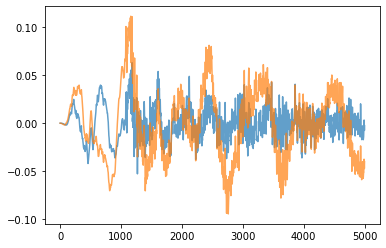

In [60]:
for chan in wave.unbind(0):
    plt.plot(chan[:5000], alpha=0.7)

In [6]:
# mix down to mono
mono = wave.mean(0)

In [7]:
# quick preemphasis filter
def preemph(x, a=1.1):
    x_ = torch.cat((torch.zeros_like(x[:1]), x), 0)
    y = a*x_[1:] - x_[:-1]
    return y
    
def deemph(ys, a=1.1):
    x_ = torch.zeros_like(ys[:1])
    xs = []
    for y in ys:
        x = (y + x_)/a
        x_ = x
        xs.append(x)
    return torch.cat(xs, 0)

In [8]:
filt = preemph(mono)

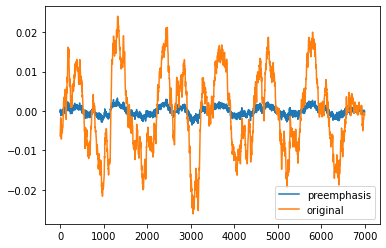

In [9]:
plt.plot(filt[-7000:], label='preemphasis')
plt.plot(mono[-7000:], label='original')
plt.legend()

## build time encoding

In [11]:
t = torch.arange(len(filt))/sr # sample times in seconds

In [12]:
n_freq = 256 # number of of frequencies
f_lo, f_hi = 0.1, sr/2 # min, max exponentially spaced frequencies in hz
freq = torch.linspace(math.log(f_lo), math.log(f_hi), n_freq).exp()
phase = freq * t[:,None] * math.pi * 2
feat = torch.cat((phase.sin(), phase.cos()), 1)

In [13]:
# freq

torch.Size([384000, 512])

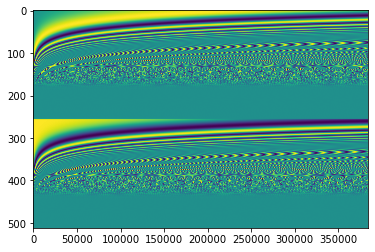

In [14]:
plt.imshow(feat.T, aspect='auto')
feat.shape

## define model

In [45]:
# TODO: effect of dropout?
h = 256
model = torch.jit.script(
    nn.Sequential(
#         nn.Dropout(0.5), 
        nn.Linear(2*n_freq, h), nn.ReLU(),# nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), #nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), #nn.Dropout(0.1),
        nn.Linear(h, 1, bias=False), nn.Tanh()
    )
)

## train

In [46]:
seen_idx = torch.zeros(len(filt))

In [47]:
batch_size = 1024

In [48]:
# TODO: learning rate
opt = torch.optim.Adam(model.parameters(), 1e-3)
losses = []

100%|██████████| 10000/10000 [06:23<00:00, 26.08it/s]


0.0008728708489798009

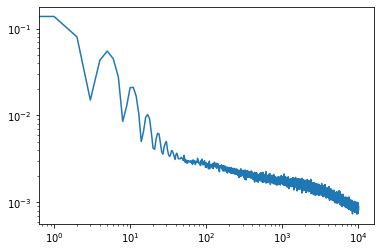

In [49]:
model.train()
for _ in tqdm(range(10000)):
    model.zero_grad()
    idx = torch.multinomial((3*(seen_idx.mean()-seen_idx)).exp(), batch_size)
    batch = feat[idx, :]
    target = filt[idx]
    seen_idx[idx] += 1
#     batch = feat[:1000]
#     target = mono[:1000]
    result = model(batch)[:,0]
    loss = (result - target).abs().mean()
#     loss = (result - target).pow(2).sum().sqrt()
    loss.backward()
    opt.step()
    losses.append(loss.item())
model.eval()
plt.plot(losses)
plt.loglog()
loss.item()

## inspect reconstruction

In [50]:
recon = deemph(model(feat)[:,0])
recon.shape

torch.Size([384000])

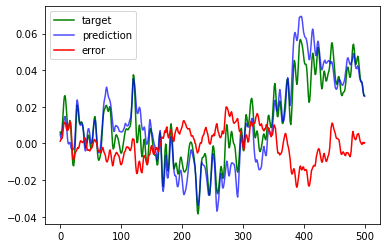

In [51]:
s,d=2000,500
# s,d=1000,200
plt.plot(mono[s:s+d], label='target', c='g')
plt.plot((recon).detach()[s:s+d], label='prediction', c='b', alpha=0.7)
plt.plot((mono-recon).detach()[s:s+d], label='error', c='r')
plt.legend()

In [52]:
spect = torchaudio.transforms.Spectrogram(4096, sr//25, sr//100)
eps = 1e-6

Text(0.5, 1.0, 'reconstruction spectrogram')

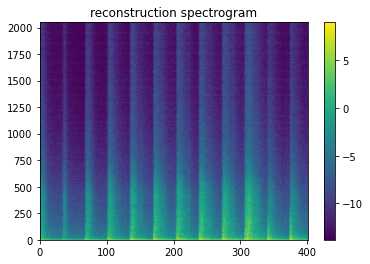

In [53]:
recon_spect = (spect(recon.detach())+eps).log()
plt.imshow(recon_spect, aspect='auto', origin='lower')
plt.colorbar()
plt.title('reconstruction spectrogram')

Text(0.5, 1.0, 'target spectrogram')

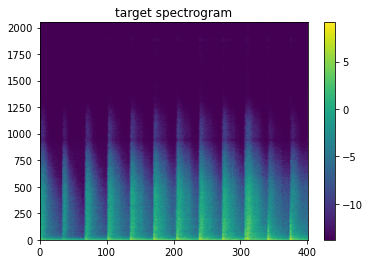

In [54]:
gt_spect = (spect(mono)+eps).log()
plt.imshow(gt_spect, aspect='auto', origin='lower')
plt.colorbar()
plt.title('target spectrogram')

In [55]:
display('reconstruction', Audio(recon.detach(), rate=sr))
display('ground truth', Audio(mono, rate=sr))

'reconstruction'

'ground truth'

## inspect extrapolation

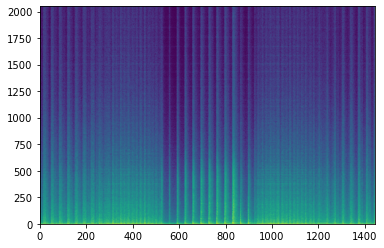

In [56]:
t_ext = torch.arange(-500000, len(mono)+500000)/sr
phase_ext = freq * t_ext[:,None] * math.pi * 2
feat_ext = torch.cat((phase_ext.sin(), phase_ext.cos()), 1)
ext = deemph(model(feat_ext)[:,0].detach())
ext_spect = (spect(ext)+eps).log()
plt.imshow(ext_spect, aspect='auto', origin='lower')

Text(0.5, 1.0, 'detail centered on t=0')

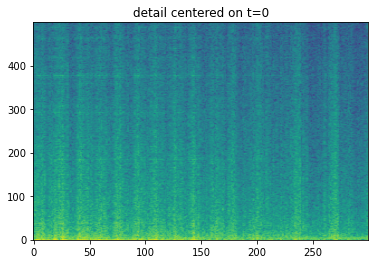

In [57]:
plt.imshow(ext_spect[:500,1000:1300], aspect='auto', origin='lower')
plt.title('detail centered on t=0')

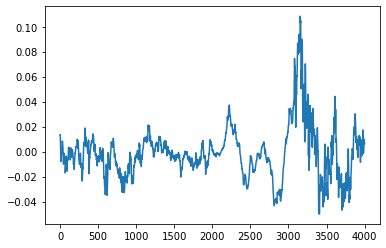

In [58]:
plt.plot(ext[498000:502000])

In [59]:
display('extrapolation', Audio(ext, rate=sr))

'extrapolation'